In [0]:
import numpy as np
np.random.seed(42)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
data=pd.read_json("/content/drive/My Drive/sarcasm/Sarcasm_Headlines_Dataset.json", lines=True)

In [0]:
text = data.headline.tolist()
label = np.array(data.is_sarcastic.tolist())

In [0]:
len(text),len(label)

(26709, 26709)

In [0]:
import keras

from keras.preprocessing.text import Tokenizer
# create the tokenizer
t = Tokenizer()
# fit the tokenizer on the documents
seq=t.fit_on_texts(text)

Using TensorFlow backend.


In [0]:
vocab_size=len(t.word_index)+1

In [0]:
vocab_size

29657

In [0]:
sequences = t.texts_to_sequences(text)

In [0]:
from keras.preprocessing.sequence import pad_sequences
train=pad_sequences(sequences, maxlen=100,padding='pre')

In [0]:
train.shape

(26709, 100)

In [0]:
from sklearn.model_selection import train_test_split

X_train,X_testVal,y_train,y_testVal=train_test_split(train,label,test_size=0.3,stratify=label)
X_val,X_test,y_val,y_test=train_test_split(X_testVal,y_testVal,test_size=0.5,stratify=y_testVal)

In [0]:
y_train.shape

(18696,)

In [0]:
np.unique(y_train,return_counts=True)

(array([0, 1]), array([10489,  8207]))

In [0]:
from imblearn.over_sampling import RandomOverSampler
rus = RandomOverSampler(return_indices=True)
X_rus_train, y_rus_train, id_rus = rus.fit_sample(X_train, y_train)

In [0]:
np.unique(y_rus_train,return_counts=True)

(array([0, 1]), array([10489, 10489]))

In [0]:
from keras.callbacks import History, EarlyStopping
hist=History()
early=EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=False)

# **LSTM on data**

In [0]:
from keras.layers import Embedding, CuDNNLSTM, Dense, Dropout
from keras.models import Sequential
from keras import optimizers
import keras.utils as ku
from keras import regularizers
opt=optimizers.adam(lr=1e-4,decay=0.1)
model=Sequential()
model.add(Embedding(input_dim=29657,output_dim=200,embeddings_initializer='uniform'))
model.add(CuDNNLSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(CuDNNLSTM(100))
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [0]:
model.fit(X_rus_train,ku.to_categorical(y_rus_train,num_classes=2),epochs=15,
    validation_data=(X_val,ku.to_categorical(y_val,num_classes=2)),callbacks=[hist,early],shuffle=True)

Train on 20978 samples, validate on 4006 samples
Epoch 1/15
20978/20978 [==============================] - 40s 2ms/step - loss: 0.6922 - acc: 0.5476 - val_loss: 0.6914 - val_acc: 0.6108
Epoch 2/15
20978/20978 [==============================] - 35s 2ms/step - loss: 0.6916 - acc: 0.5921 - val_loss: 0.6911 - val_acc: 0.6273
Epoch 3/15
20978/20978 [==============================] - 32s 2ms/step - loss: 0.6914 - acc: 0.6056 - val_loss: 0.6910 - val_acc: 0.6385
Epoch 4/15
20978/20978 [==============================] - 30s 1ms/step - loss: 0.6912 - acc: 0.6180 - val_loss: 0.6909 - val_acc: 0.6453
Epoch 5/15
20978/20978 [==============================] - 30s 1ms/step - loss: 0.6910 - acc: 0.6319 - val_loss: 0.6908 - val_acc: 0.6485
Epoch 6/15
20978/20978 [==============================] - 30s 1ms/step - loss: 0.6909 - acc: 0.6348 - val_loss: 0.6907 - val_acc: 0.6523
Epoch 7/15
20978/20978 [==============================] - 30s 1ms/step - loss: 0.6909 - acc: 0.6341 - val_loss: 0.6906 - val_acc:

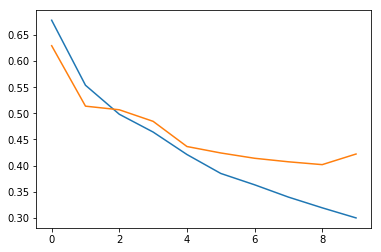

In [0]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

In [0]:
y_te_pred=model.predict_classes(X_test)

In [0]:
y_tr_pred=model.predict_classes(X_train)

In [0]:
from sklearn.metrics import accuracy_score,f1_score,precision_recall_fscore_support
print(accuracy_score(y_test,y_te_pred))
print(f1_score(y_test,y_te_pred))
precision_recall_fscore_support(y_test,y_te_pred)

0.8188170701272772
0.8043126684636118


(array([0.87013619, 0.76473603]),
 array([0.79581851, 0.84820921]),
 array([0.8313197 , 0.80431267]),
 array([2248, 1759]))

In [0]:
print(accuracy_score(y_train,y_tr_pred))
print(f1_score(y_train,y_tr_pred))
precision_recall_fscore_support(y_train,y_tr_pred)

0.8811510483525888
0.8717386284922651


(array([0.93151686, 0.82823297]),
 array([0.85070073, 0.92006823]),
 array([0.88927646, 0.87173863]),
 array([10489,  8207]))